# Data Cleaning and Preprocessing


Imports


In [1]:
import pandas as pd
import numpy as np
from fitter import Fitter, get_common_distributions
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from datetime import datetime, timedelta
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

pd.set_option("future.no_silent_downcasting", True)

Read the orders dataset into a pandas dataframe


In [2]:
orders_df = pd.read_csv("../Data/orders_data_competition.csv")

In [3]:
orders_df.head()

,Order ID,Account ID,Market Key,Security ID,Order Type,Order Time,Order Via,Is Completed,Is Canceled,Expire Date,Execution Status,quantity,Price,Sector Name,Executed Quantity,Quantity
0,0,2312,Egypt,0,Buy,2024-01-10 10:16:10.000,Online,1,0,2024-01-10 00:00:00.000,Executed,100,66.30,Real Estate,100,100
1,1,1196,Egypt,0,Sell,2024-01-10 10:16:11.000,Online,1,0,2024-01-10 00:00:00.000,Executed,200,66.00,Real Estate,200,200
2,2,1759,Egypt,0,Buy,2024-01-10 10:16:12.000,Online,0,1,2024-01-10 00:00:00.000,Not Executed,200,65.00,Real Estate,0,200
3,3,4476,Egypt,1,Sell,2024-01-10 10:16:16.000,Online,0,1,2024-01-10 00:00:00.000,Not Executed,820,75.20,Financials,0,820
4,4,838,Egypt,2,Sell,2024-01-10 10:16:18.000,Online,0,1,2024-01-10 00:00:00.000,Not Executed,500,10.68,Materials,0,500


Read the clients dataset into a pandas dataframe


In [4]:
clients_df = pd.read_csv("../Data/clients_data_competition.csv")

In [5]:
clients_df.head()

,Client ID,Account ID,Gender,Risk Rate,Company Name,Is Closed,Is Dormant,Is Profile Suspended,Is Client Suspended,Client Type Name,OpenDate,BirthDate
0,0,0,Male,Low,HSB,0,0.0,0,0,Individuals,2/16/2014,1990-07-27
1,1,1,Female,Low,HSB,0,-1.0,1,0,Individuals,2/16/2014,1963-10-22
2,2,2,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1971-05-14
3,3,3,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1953-01-14
4,4,4,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1976-06-09


## Account Level Dataset


### Orders Data


**_We created another dataframe "agg_orders" which represents the aggregate orders of each account_**


Drop the rows with null values


In [6]:
orders_df.dropna(inplace=True)

In [7]:
orders_df = orders_df[orders_df["Order Via"] == "Online"]

In [8]:
orders_df.drop(columns=["Order Via", "Security ID"], inplace=True)

In [9]:
account_ids_to_remove = clients_df[
    (clients_df["Client Type Name"] != "Individuals")
    | (clients_df["Company Name"] != "HSB")
]["Account ID"].unique()

# Remove the accounts from the accounts dataframe where Client Type Name is not 'individuals'
clients_df = clients_df[~clients_df["Account ID"].isin(account_ids_to_remove)]

# Remove the orders of these accounts from the orders dataframe
orders_df = orders_df[~orders_df["Account ID"].isin(account_ids_to_remove)]

In [10]:
clients_df.drop(columns=["Client Type Name", "Company Name"], inplace=True)

In [11]:
len(clients_df["Account ID"].unique())

11323

In [12]:
len(orders_df["Account ID"].unique())

6715

In [13]:
# Check if there are any accounts in the orders dataframe that are not in the accounts dataframe
accounts_in_orders_not_in_accounts = orders_df[
    ~orders_df["Account ID"].isin(clients_df["Account ID"])
]
if accounts_in_orders_not_in_accounts.empty:
    print(
        "There are no accounts in the orders dataframe that are not in the accounts dataframe."
    )
else:
    print(
        "There are accounts in the orders dataframe that are not in the accounts dataframe."
    )

# Check if there are any accounts in the accounts dataframe that are not in the orders dataframe
accounts_in_accounts_not_in_orders = clients_df[
    ~clients_df["Account ID"].isin(orders_df["Account ID"])
]
if accounts_in_accounts_not_in_orders.empty:
    print(
        "There are no accounts in the accounts dataframe that are not in the orders dataframe."
    )
else:
    print(
        "There are accounts in the accounts dataframe that are not in the orders dataframe."
    )

There are no accounts in the orders dataframe that are not in the accounts dataframe.
There are accounts in the accounts dataframe that are not in the orders dataframe.


In [14]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1833491 entries, 0 to 1987940
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Order ID           int64  
 1   Account ID         int64  
 2   Market Key         object 
 3   Order Type         object 
 4   Order Time         object 
 5   Is Completed       int64  
 6   Is Canceled        int64  
 7   Expire Date        object 
 8   Execution Status   object 
 9   quantity           int64  
 10  Price              float64
 11  Sector Name        object 
 12  Executed Quantity  int64  
 13  Quantity           int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 209.8+ MB


Initialize a new Dataframe to store the aggregate orders per account


In [15]:
agg_orders = pd.DataFrame()

Add an AccountID column to the aggregate orders df


In [16]:
agg_orders["AccountID"] = clients_df["Account ID"].unique()

Compute and add the number of orders for each account


In [17]:
# Add a NumOfOrders column that has the number of orders for each account
agg_orders["NumOfOrders"] = orders_df.groupby("Account ID").size()

# Set the number of orders for the accounts that didn't place any order to 0
agg_orders["NumOfOrders"] = agg_orders["NumOfOrders"].fillna(0)

# Convert the type to int
agg_orders["NumOfOrders"] = agg_orders["NumOfOrders"].astype(int)

Compute and add the last order date for each account


In [18]:
# Convert the 'order_date' column to datetime
orders_df["Order Time"] = pd.to_datetime(orders_df["Order Time"])

# Create a new dataframe with the last order date for each account
agg_orders["LastOrder"] = orders_df.groupby("Account ID")["Order Time"].max()

# Convert the LastOrder column to datetime
agg_orders["LastOrder"] = pd.to_datetime(agg_orders["LastOrder"], format="%d-%m-%Y")

Compute and add the first order date for each account


In [19]:
# Create a new dataframe with the last order date for each account
agg_orders["FirstOrder"] = orders_df.groupby("Account ID")["Order Time"].min()

# Convert the LastOrder column to datetime
agg_orders["FirstOrder"] = pd.to_datetime(agg_orders["FirstOrder"], format="%d-%m-%Y")

Compute and add the number of completed orders for each account


In [20]:
# Add a NumOfCompleted column that has the number of completed orders for each account
agg_orders["NumOfCompleted"] = orders_df.groupby("Account ID")["Is Completed"].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["NumOfCompleted"] = agg_orders["NumOfCompleted"].fillna(0)

# # Convert the type to int
agg_orders["NumOfCompleted"] = agg_orders["NumOfCompleted"].astype(int)

Compute and add the number of canceled for each account


In [21]:
# Add a NumOfCanceled column that has the number of completed orders for each account
agg_orders["NumOfCanceled"] = orders_df.groupby("Account ID")["Is Canceled"].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["NumOfCanceled"] = agg_orders["NumOfCanceled"].fillna(0)

# # Convert the type to int
agg_orders["NumOfCanceled"] = agg_orders["NumOfCanceled"].astype(int)

Compute and add the average price of orders for each account


In [22]:
# Add a AvgPrice column that has the number of completed orders for each account
agg_orders["AvgPrice"] = (
    orders_df.groupby("Account ID")["Price"].sum()
    / orders_df.groupby("Account ID").size()
)

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["AvgPrice"] = agg_orders["AvgPrice"].fillna(0.0)

Compute and add the total executed quantity of orders for each account


In [23]:
# Add a TotalExecutedQuantity column that has the number of completed orders for each account
agg_orders["TotalExecutedQuantity"] = orders_df.groupby("Account ID")[
    "Executed Quantity"
].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["TotalExecutedQuantity"] = agg_orders["TotalExecutedQuantity"].fillna(0)

# # Convert the type to int
agg_orders["TotalExecutedQuantity"] = agg_orders["TotalExecutedQuantity"].astype(int)

Compute and add the total quantity of orders for each account


In [24]:
# Add a TotalQuantity column that has the number of completed orders for each account
agg_orders["TotalQuantity"] = orders_df.groupby("Account ID")["Quantity"].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["TotalQuantity"] = agg_orders["TotalQuantity"].fillna(0)

# # Convert the type to int
agg_orders["TotalQuantity"] = agg_orders["TotalQuantity"].astype(int)

Define a function to convert a categorical feature to its TFIDF dataframe and concatenate it with the aggregate orders dataframe


In [25]:
def FrequencyEncoder(column_name: str):
    temp = pd.get_dummies(orders_df, columns=[column_name])
    temp.replace({True: 1, False: 0}, inplace=True)

    frequency_encode_df = pd.DataFrame(data=agg_orders.iloc[:, 0])

    for word in orders_df[column_name].unique():
        col_name = f"{column_name}_{word}"

        frequency_encode_df[col_name.replace(" ", "")] = (
            temp.groupby("Account ID")[col_name].sum()
            / temp.groupby("Account ID").size()
        )

        frequency_encode_df[col_name.replace(" ", "")] = frequency_encode_df[
            col_name.replace(" ", "")
        ].fillna(0)

        frequency_encode_df[col_name.replace(" ", "")] = frequency_encode_df[
            col_name.replace(" ", "")
        ].astype(float)

    return pd.concat([agg_orders, frequency_encode_df.iloc[:, 1:]], axis=1)

Compute and add the Frequency Encoding of the Security ID column


In [26]:
# agg_orders = FrequencyEncoder("Security ID")

Compute and add the Frequency Encoding of the Order Type column


In [27]:
agg_orders = FrequencyEncoder("Order Type")

Compute and add the Frequency Encoding of the Execution Status column


In [28]:
agg_orders = FrequencyEncoder("Execution Status")

Compute and add the Frequency Encoding of the Sector Name column


In [29]:
agg_orders = FrequencyEncoder("Sector Name")

Display the head of the agg_orders dataframe


In [30]:
agg_orders.head()

,AccountID,NumOfOrders,LastOrder,FirstOrder,NumOfCompleted,NumOfCanceled,AvgPrice,TotalExecutedQuantity,TotalQuantity,OrderType_Buy,...,SectorName_INVESTMENT,SectorName_TelecommunicationServices,SectorName_REALESTATE,SectorName_Telecommunications,SectorName_FOOD,SectorName_Others,SectorName_Tourism,SectorName_ConsumerServices,SectorName_Utilities,SectorName_PharmaceuticalIndustries
0,0,0,NaT,NaT,0,0,0.000000,0,0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,NaT,NaT,0,0,0.000000,0,0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,21,2024-02-28 11:06:33,2022-01-04 12:06:31,17,2,7.652667,123895,137395,0.857143,...,0.095238,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,87,2024-03-10 12:32:34,2023-01-17 12:02:35,64,11,71.908161,682538,908478,0.471264,...,0.000000,0.022989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,30,2024-02-26 12:47:33,2022-01-11 11:05:32,8,10,2.846267,356686,594953,0.066667,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Display the info of the agg_orders dataframe


In [31]:
agg_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11323 entries, 0 to 11322
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   AccountID                             11323 non-null  int64         
 1   NumOfOrders                           11323 non-null  int64         
 2   LastOrder                             5512 non-null   datetime64[ns]
 3   FirstOrder                            5512 non-null   datetime64[ns]
 4   NumOfCompleted                        11323 non-null  int64         
 5   NumOfCanceled                         11323 non-null  int64         
 6   AvgPrice                              11323 non-null  float64       
 7   TotalExecutedQuantity                 11323 non-null  int64         
 8   TotalQuantity                         11323 non-null  int64         
 9   OrderType_Buy                         11323 non-null  float64       
 10

### Clients Data


Drop the rows with null values


In [32]:
clients_df.dropna(inplace=True)

In [33]:
clients_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11323 entries, 0 to 13521
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Client ID             11323 non-null  int64  
 1   Account ID            11323 non-null  int64  
 2   Gender                11323 non-null  object 
 3   Risk Rate             11323 non-null  object 
 4   Is Closed             11323 non-null  int64  
 5   Is Dormant            11323 non-null  float64
 6   Is Profile Suspended  11323 non-null  int64  
 7   Is Client Suspended   11323 non-null  int64  
 8   OpenDate              11323 non-null  object 
 9   BirthDate             11323 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 973.1+ KB


Drop the suspended clients


In [34]:
clients_df = clients_df[clients_df["Is Client Suspended"] == 0]

In [35]:
clients_df.drop(columns="Is Client Suspended", inplace=True)

Convert the OpenDate column to DateTime object


In [36]:
# Convert the OpenDate column to datetime
clients_df["OpenDate"] = pd.to_datetime(clients_df["OpenDate"], format="%m/%d/%Y")

Convert the BirthDate column to DateTime object, and calculate the age of the client


In [37]:
# Convert the BirthDate column to datetime
clients_df["BirthDate"] = pd.to_datetime(clients_df["BirthDate"], format="%Y-%m-%d")

In [38]:
def calculate_age(birth_date):
    # Assuming birth_date is a datetime object
    today = datetime.today()
    return (
        today.year
        - birth_date.year
        - ((today.month, today.day) < (birth_date.month, birth_date.day))
    )

In [39]:
clients_df["Age"] = clients_df["BirthDate"].apply(calculate_age)

Remove all whitespaces in the column names


In [40]:
clients_df.rename(columns=lambda x: x.replace(" ", ""), inplace=True)

Display the head of the clients dataframe


In [41]:
clients_df.head()

,ClientID,AccountID,Gender,RiskRate,IsClosed,IsDormant,IsProfileSuspended,OpenDate,BirthDate,Age
0,0,0,Male,Low,0,0.0,0,2014-02-16,1990-07-27,33
1,1,1,Female,Low,0,-1.0,1,2014-02-16,1963-10-22,60
2,2,2,Male,Low,0,0.0,0,2014-02-17,1971-05-14,53
3,3,3,Male,Low,0,0.0,0,2014-02-17,1953-01-14,71
4,4,4,Male,Low,0,0.0,0,2014-02-17,1976-06-09,48


Display the info of the clients dataframe


In [42]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11222 entries, 0 to 13521
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ClientID            11222 non-null  int64         
 1   AccountID           11222 non-null  int64         
 2   Gender              11222 non-null  object        
 3   RiskRate            11222 non-null  object        
 4   IsClosed            11222 non-null  int64         
 5   IsDormant           11222 non-null  float64       
 6   IsProfileSuspended  11222 non-null  int64         
 7   OpenDate            11222 non-null  datetime64[ns]
 8   BirthDate           11222 non-null  datetime64[ns]
 9   Age                 11222 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(2)
memory usage: 964.4+ KB


### Merging


**_We will inner join the agg_orders and clients_df dataframes on the AccountID column_**


Perform the merging between both dataframes


In [43]:
df_account_level = pd.merge(clients_df, agg_orders, on="AccountID", how="inner")

In [44]:
# Get the current date
now = datetime.now()

In [45]:
order_rates_start = []
order_rates_end = []
quantity_rates_start = []
quantity_rates_end = []
avg_quantity_per_order_start = []
avg_quantity_per_order_end = []

In [46]:
for i, account in df_account_level.iterrows():
    midpointDate = account["OpenDate"] + (now - account["OpenDate"]) / 2
    openDate = account["OpenDate"]

    days_open_midpoint = (midpointDate - openDate).days
    days_midpoint_now = (now - midpointDate).days

    filtered_date_df = orders_df[
        (orders_df["Order Time"] >= openDate)
        & (orders_df["Order Time"] < midpointDate)
        & (orders_df["Account ID"] == account["AccountID"])
    ]

    filtered_df_2 = orders_df[
        (orders_df["Order Time"] >= midpointDate)
        & (orders_df["Order Time"] < now)
        & (orders_df["Account ID"] == account["AccountID"])
    ]

    num_of_orders_start = len(filtered_date_df)
    num_of_orders_end = len(filtered_df_2)

    quantity_ordered_start = filtered_date_df["Quantity"].sum()
    quantity_ordered_end = filtered_df_2["Quantity"].sum()

    avg_quantity_start = filtered_date_df["Quantity"].mean()
    avg_quantity_end = filtered_df_2["Quantity"].mean()

    order_rates_start.append(num_of_orders_start / days_open_midpoint)
    order_rates_end.append(num_of_orders_end / days_midpoint_now)

    quantity_rates_start.append(quantity_ordered_start / days_open_midpoint)
    quantity_rates_end.append(quantity_ordered_end / days_midpoint_now)

    avg_quantity_per_order_start.append(avg_quantity_start)
    avg_quantity_per_order_end.append(avg_quantity_end)

In [47]:
df_account_level["OrderRate_Start"] = pd.Series(order_rates_start)
df_account_level["OrderRate_End"] = pd.Series(order_rates_end)
df_account_level["QuantityOrderedRate_Start"] = pd.Series(quantity_rates_start)
df_account_level["QuantityOrderedRate_End"] = pd.Series(quantity_rates_end)
df_account_level["AvgQuantityPerOrder_Start"] = pd.Series(avg_quantity_per_order_start)
df_account_level["AvgQuantityPerOrder_End"] = pd.Series(avg_quantity_per_order_end)

In [48]:
df_account_level["AvgQuantityPerOrder_Start"] = df_account_level[
    "AvgQuantityPerOrder_Start"
].fillna(0)
df_account_level["AvgQuantityPerOrder_End"] = df_account_level[
    "AvgQuantityPerOrder_End"
].fillna(0)

In [49]:
df_account_level["ExecutedQuantityRatio"] = df_account_level.apply(
    lambda row: (
        1
        if row["TotalQuantity"] == 0
        else row["TotalExecutedQuantity"] / row["TotalQuantity"]
    ),
    axis=1,
)

Display the head of the dataframe


In [50]:
df_account_level.head()

,ClientID,AccountID,Gender,RiskRate,IsClosed,IsDormant,IsProfileSuspended,OpenDate,BirthDate,Age,...,SectorName_ConsumerServices,SectorName_Utilities,SectorName_PharmaceuticalIndustries,OrderRate_Start,OrderRate_End,QuantityOrderedRate_Start,QuantityOrderedRate_End,AvgQuantityPerOrder_Start,AvgQuantityPerOrder_End,ExecutedQuantityRatio
0,0,0,Male,Low,0,0.0,0,2014-02-16,1990-07-27,33,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000
1,1,1,Female,Low,0,-1.0,1,2014-02-16,1963-10-22,60,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000
2,2,2,Male,Low,0,0.0,0,2014-02-17,1971-05-14,53,...,0.0,0.0,0.0,0.0,0.011064,0.0,72.389357,0.0,6542.619048,0.901743
3,3,3,Male,Low,0,0.0,0,2014-02-17,1953-01-14,71,...,0.0,0.0,0.0,0.0,0.045838,0.0,478.650158,0.0,10442.275862,0.751298
4,4,4,Male,Low,0,0.0,0,2014-02-17,1976-06-09,48,...,0.0,0.0,0.0,0.0,0.015806,0.0,313.463119,0.0,19831.766667,0.599520


Display the info of the dataframe


In [51]:
df_account_level.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11222 entries, 0 to 11221
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   ClientID                              11222 non-null  int64         
 1   AccountID                             11222 non-null  int64         
 2   Gender                                11222 non-null  object        
 3   RiskRate                              11222 non-null  object        
 4   IsClosed                              11222 non-null  int64         
 5   IsDormant                             11222 non-null  float64       
 6   IsProfileSuspended                    11222 non-null  int64         
 7   OpenDate                              11222 non-null  datetime64[ns]
 8   BirthDate                             11222 non-null  datetime64[ns]
 9   Age                                   11222 non-null  int64         
 10

In [52]:
len(df_account_level["ClientID"].unique())

8790

## Client Level Dataset


In [53]:
df = pd.DataFrame()

In [54]:
# Create a new DataFrame with ClientID and corresponding account count
df = pd.DataFrame(
    {
        "ClientID": df_account_level.groupby("ClientID")["AccountID"].nunique().index,
    }
)

In [55]:
df["Gender"] = (df_account_level.groupby("ClientID")["Gender"].first().reset_index())[
    "Gender"
]
df["Age"] = (df_account_level.groupby("ClientID")["Age"].first().reset_index())["Age"]

df["RiskRate"] = (
    df_account_level.groupby("ClientID")["RiskRate"].first().reset_index()
)["RiskRate"]

In [56]:
df["NumOfAccounts"] = df_account_level.groupby("ClientID").size().values

In [57]:
df["NumOfClosedAccounts"] = (
    df_account_level.groupby("ClientID")["IsClosed"].sum().values
)

In [58]:
df["NumOfSuspendedAccounts"] = (
    df_account_level.groupby("ClientID")["IsProfileSuspended"].sum().values
)

In [59]:
df["NumOfOrders"] = df_account_level.groupby("ClientID")["NumOfOrders"].sum().values

In [60]:
df["NumOfCompletedOrders"] = (
    df_account_level.groupby("ClientID")["NumOfCompleted"].sum().values
)

In [61]:
df["NumOfCanceledOrders"] = (
    df_account_level.groupby("ClientID")["NumOfCanceled"].sum().values
)

In [62]:
df["CompletedOrdersRatio"] = df.apply(
    lambda row: (
        1
        if row["NumOfOrders"] == 0
        else row["NumOfCompletedOrders"] / row["NumOfOrders"]
    ),
    axis=1,
)

In [63]:
df["CanceledOrdersRatio"] = df.apply(
    lambda row: (
        1
        if row["NumOfOrders"] == 0
        else row["NumOfCanceledOrders"] / row["NumOfOrders"]
    ),
    axis=1,
)

In [64]:
df["TotalExecutedQuantity"] = (
    df_account_level.groupby("ClientID")["TotalExecutedQuantity"].sum().values
)

In [65]:
df["TotalQuantity"] = df_account_level.groupby("ClientID")["TotalQuantity"].sum().values

In [66]:
df["AvgPrice"] = (
    df_account_level.groupby("ClientID")["AvgPrice"].sum()
    / df_account_level.groupby("ClientID").size()
).values

In [67]:
agg_dict = {}

for col in df_account_level.columns:
    if "OrderType" in col or "ExecutionStatus" in col or "SectorName" in col:
        agg_dict[col] = (
            df_account_level.groupby("ClientID")[col].sum()
            / df_account_level.groupby("ClientID").size()
        ).values

df = pd.concat([df, pd.DataFrame(agg_dict)], axis=1)

In [68]:
df["LastOrderDateAcrossAccounts"] = (
    df_account_level.groupby("ClientID")["LastOrder"].max().values
)

df["LastOrderDateAcrossAccounts"] = pd.to_datetime(
    df["LastOrderDateAcrossAccounts"].dt.date
)

Define a function so that we can compute if the account is dormant or not.

If the account has not placed any order, we set the Is Dormant value to -1, so that we can isolate the accounts who have not placed any orders.


In [69]:
def check_dormant(date):
    one_year_before_now = datetime.now() - timedelta(days=183)

    if date < one_year_before_now:
        return 1
    else:
        return 0

Recompute the Is Dormant column


In [70]:
df["IsDormant"] = df["LastOrderDateAcrossAccounts"].apply(check_dormant)

In [71]:
df["AvgOrderRate_Start"] = (
    df_account_level.groupby("ClientID")["OrderRate_Start"].mean().values
)

In [72]:
df["AvgOrderRate_End"] = (
    df_account_level.groupby("ClientID")["OrderRate_End"].mean().values
)

In [73]:
df["AvgOrderRate_Difference"] = df["AvgOrderRate_End"] - df["AvgOrderRate_Start"]

In [74]:
df["AvgQuantityOrderedRate_Start"] = (
    df_account_level.groupby("ClientID")["QuantityOrderedRate_Start"].mean().values
)

In [75]:
df["AvgQuantityOrderedRate_End"] = (
    df_account_level.groupby("ClientID")["QuantityOrderedRate_End"].mean().values
)

In [76]:
df["AvgQuantityOrderedRate_Difference"] = (
    df["AvgQuantityOrderedRate_End"] - df["AvgQuantityOrderedRate_Start"]
)

In [77]:
df["AvgQuantityPerAccount_Start"] = (
    df_account_level.groupby("ClientID")["AvgQuantityPerOrder_Start"].mean().values
)

In [78]:
df["AvgQuantityPerAccount_End"] = (
    df_account_level.groupby("ClientID")["AvgQuantityPerOrder_End"].mean().values
)

In [79]:
df["AvgQuantityPerAccount_Difference"] = (
    df["AvgQuantityPerAccount_End"] - df["AvgQuantityPerAccount_Start"]
)

In [80]:
df["AvgExecutedQuantityRatio"] = (
    df_account_level.groupby("ClientID")["ExecutedQuantityRatio"].mean().values
)

In [81]:
df["ClosedAccountsRatio"] = df["NumOfClosedAccounts"] / df["NumOfAccounts"]

In [82]:
df["SuspendedAccountsRatio"] = df["NumOfSuspendedAccounts"] / df["NumOfAccounts"]

Drop clients who have 0 orders


In [83]:
df = df[df["NumOfOrders"] > 0]

In [84]:
# df.drop(
#     columns=[
#         "TotalExecutedQuantity",
#         "TotalQuantity",
#         "LastOrderDateAcrossAccounts",
#         "AvgOrderRate_Start",
#         "AvgOrderRate_End",
#         "AvgQuantityOrderedRate_Start",
#         "AvgQuantityOrderedRate_End",
#         "AvgQuantityPerAccount_Start",
#         "AvgQuantityPerAccount_End",
#         "AvgQuantityPerAccount_Difference",
#         "NumOfClosedAccounts",
#         "NumOfAccounts",
#         "NumOfSuspendedAccounts",
#         "NumOfOrders",
#         "NumOfCompletedOrders",
#         "NumOfCanceledOrders",
#     ],
#     inplace=True,
# )

In [85]:
df.head()

,ClientID,Gender,Age,RiskRate,NumOfAccounts,NumOfClosedAccounts,NumOfSuspendedAccounts,NumOfOrders,NumOfCompletedOrders,NumOfCanceledOrders,...,AvgOrderRate_Difference,AvgQuantityOrderedRate_Start,AvgQuantityOrderedRate_End,AvgQuantityOrderedRate_Difference,AvgQuantityPerAccount_Start,AvgQuantityPerAccount_End,AvgQuantityPerAccount_Difference,AvgExecutedQuantityRatio,ClosedAccountsRatio,SuspendedAccountsRatio
2,2,Male,53,Low,1,0,0,21,17,2,...,0.011064,0.00,72.389357,72.389357,0.00,6542.619048,6542.619048,0.901743,0.0,0.0
3,3,Male,71,Low,1,0,0,87,64,11,...,0.045838,0.00,478.650158,478.650158,0.00,10442.275862,10442.275862,0.751298,0.0,0.0
4,4,Male,48,Low,2,0,0,30,8,10,...,0.008954,0.00,166.156078,166.156078,0.00,14400.383333,14400.383333,0.799760,0.0,0.0
7,7,Male,70,Not Assigned,1,0,0,28,19,6,...,-0.333333,348.25,0.000000,-348.250000,1044.75,0.000000,-1044.750000,0.632585,0.0,0.0
8,8,Male,38,Medium,3,0,0,65,35,7,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.858656,0.0,0.0


In [86]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 4826 entries, 2 to 8788
Data columns (total 56 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   ClientID                              4826 non-null   int64         
 1   Gender                                4826 non-null   object        
 2   Age                                   4826 non-null   int64         
 3   RiskRate                              4826 non-null   object        
 4   NumOfAccounts                         4826 non-null   int64         
 5   NumOfClosedAccounts                   4826 non-null   int64         
 6   NumOfSuspendedAccounts                4826 non-null   int64         
 7   NumOfOrders                           4826 non-null   int64         
 8   NumOfCompletedOrders                  4826 non-null   int64         
 9   NumOfCanceledOrders                   4826 non-null   int64         
 10  Compl

## Binning


Columns to be binned:

-   AvgOrderRate_Difference
-   AvgQuantityOrderedRate_Difference
-   CompletedOrdersRatio
-   CanceledOrdersRatio
-   ClosedAccountsRatio


### AvgOrderRate_Difference


In [87]:
print(f"Difference is < 0: {len(df[df["AvgOrderRate_Difference"] < 0])}")
print(f"Difference is 0: {len(df[df["AvgOrderRate_Difference"] == 0])}")
print(f"Difference > 0: {len(df[df["AvgOrderRate_Difference"] > 0])}")

Difference is < 0: 1039
Difference is 0: 1527
Difference > 0: 2260


<Axes: xlabel='AvgOrderRate_Difference', ylabel='Count'>

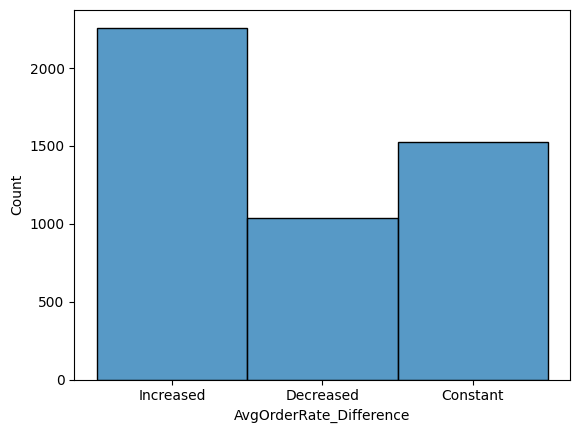

In [103]:
sns.histplot(data=df, x="AvgOrderRate_Difference", log_scale=True)

In [89]:
def bin_AvgOrderRate_Difference(value):
    if value < 0:
        return "Decreased"
    elif value == 0:
        return "Constant"
    else:
        return "Increased"

In [90]:
df["AvgOrderRate_Difference"] = df["AvgOrderRate_Difference"].apply(
    bin_AvgOrderRate_Difference
)

### AvgQuantityOrderedRate_Difference


In [91]:
print(f"Difference is < 0: {len(df[df["AvgQuantityOrderedRate_Difference"] < 0])}")
print(f"Difference is 0: {len(df[df["AvgQuantityOrderedRate_Difference"] == 0])}")
print(f"Difference > 0: {len(df[df["AvgQuantityOrderedRate_Difference"] > 0])}")

Difference is < 0: 1022
Difference is 0: 1521
Difference > 0: 2283


<Axes: xlabel='AvgQuantityOrderedRate_Difference', ylabel='Count'>

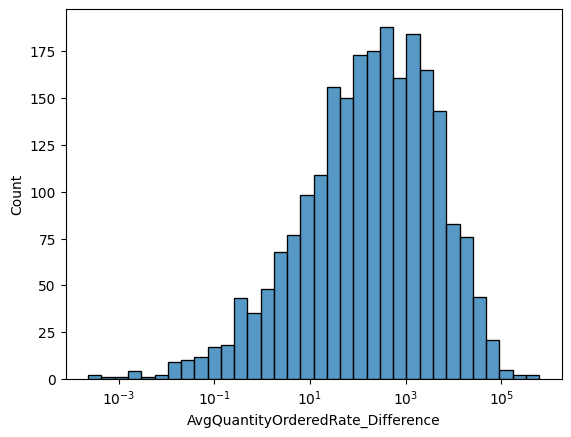

In [92]:
sns.histplot(data=df, x="AvgQuantityOrderedRate_Difference", log_scale=True)

In [93]:
def bin_AvgQuantityOrderedRate_Difference(value):
    if value < 0:
        return "Lower"
    elif value == 0:
        return "Constant"
    else:
        return "Higher"

In [94]:
df["AvgQuantityOrderedRate_Difference"] = df["AvgQuantityOrderedRate_Difference"].apply(
    bin_AvgQuantityOrderedRate_Difference
)

### CompletedOrdersRatio


<Axes: xlabel='CompletedOrdersRatio', ylabel='Count'>

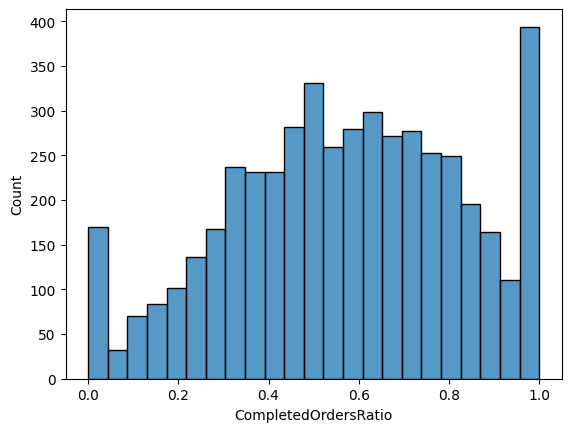

In [95]:
sns.histplot(data=df, x="CompletedOrdersRatio", log_scale=False)

In [96]:
def bin_CompletedOrdersRatio(value):
    if value == 0:
        return "None"
    elif value > 0 and value < 0.5:
        return "Little"
    elif value >= 0.5 and value < 1:
        return "Most"
    else:
        return "All"

In [97]:
df["CompletedOrdersRatio"] = df["CompletedOrdersRatio"].apply(bin_CompletedOrdersRatio)

### CanceledOrdersRatio


<Axes: xlabel='CanceledOrdersRatio', ylabel='Count'>

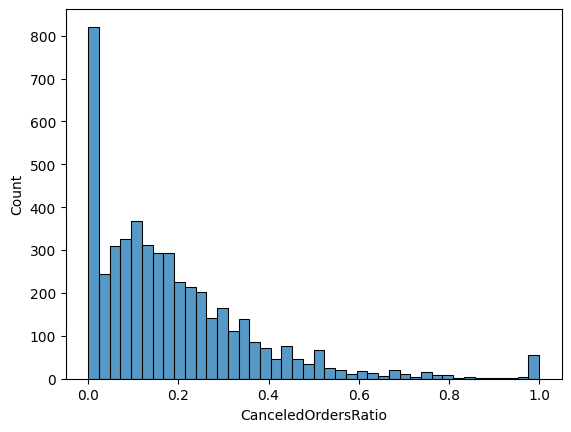

In [98]:
sns.histplot(data=df, x="CanceledOrdersRatio", log_scale=False)

In [99]:
def bin_CanceledOrdersRatio(value):
    if value == 0:
        return "None"
    elif 0 < value <= 0.1:
        return "Little"
    elif 0.1 < value <= 0.3:
        return "Moderate"
    elif 0.3 < value < 1:
        return "Most"
    elif value == 1:
        return "All"

In [100]:
df["CanceledOrdersRatio"] = df["CanceledOrdersRatio"].apply(bin_CanceledOrdersRatio)

### ClosedAccountsRatio


In [104]:
len(df[df["SuspendedAccountsRatio"] == 1])

780

<Axes: xlabel='SuspendedAccountsRatio', ylabel='Count'>

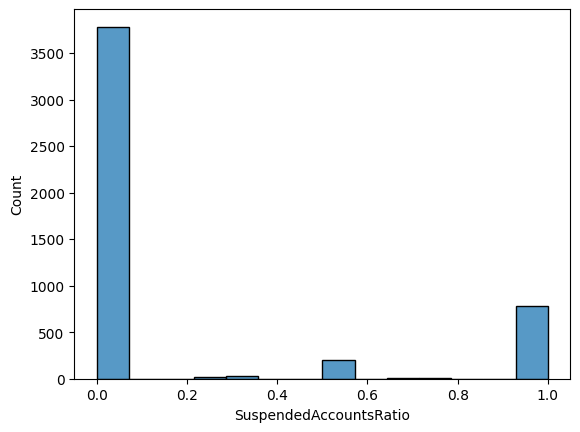

In [101]:
sns.histplot(data=df, x="SuspendedAccountsRatio", log_scale=False)

<Axes: xlabel='ClosedAccountsRatio', ylabel='Count'>

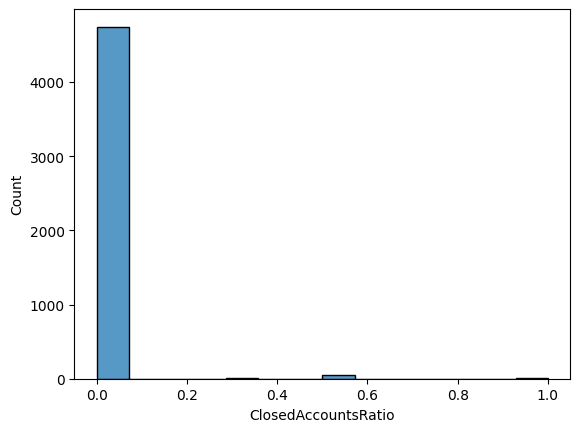

In [101]:
sns.histplot(data=df, x="ClosedAccountsRatio", log_scale=False)

In [102]:
def bin_ClosedAccountsRatio(value):
    if value == 0:
        return "None"
    elif 0 < value <= 0.5:
        return "Some"
    elif 0.5 < value < 1:
        return "Many"
    elif value == 1:
        return "All"

In [103]:
df["ClosedAccountsRatio"] = df["ClosedAccountsRatio"].apply(bin_ClosedAccountsRatio)

## Defining The Label


**_We defined our label to be a combination of multiple features_**


Create the label


In [104]:
df["Churned"] = (df["IsDormant"] == 1) | (df["SuspendedAccountsRatio"] >= 0.5)

df = df.replace({True: 1, False: 0})

df["Churned"] = df["Churned"].astype(int)

In [105]:
print(len(df[df["Churned"] == 1]) / len(df))
print(len(df[df["Churned"] == 0]) / len(df))

0.4778284293410692
0.5221715706589308


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4826 entries, 2 to 8788
Data columns (total 57 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   ClientID                              4826 non-null   int64         
 1   Gender                                4826 non-null   object        
 2   Age                                   4826 non-null   int64         
 3   RiskRate                              4826 non-null   object        
 4   NumOfAccounts                         4826 non-null   int64         
 5   NumOfClosedAccounts                   4826 non-null   int64         
 6   NumOfSuspendedAccounts                4826 non-null   int64         
 7   NumOfOrders                           4826 non-null   int64         
 8   NumOfCompletedOrders                  4826 non-null   int64         
 9   NumOfCanceledOrders                   4826 non-null   int64         
 10  Compl

In [107]:
df.to_csv("../Data/visualization_data.csv", index=False)

## OHE


The columns to be one-hot encoded


In [108]:
columns = [
    "Gender",
    "RiskRate",
    "AvgOrderRate_Difference",
    "AvgQuantityOrderedRate_Difference",
    "CompletedOrdersRatio",
    "CanceledOrdersRatio",
    "ClosedAccountsRatio",
]

OHE these columns


In [109]:
df = pd.get_dummies(
    df,
    columns=columns,
    dtype=int,
)

Drop the columns used for creating the label to remove bias, also drop the unnecessary columns


In [110]:
df.drop(
    columns=[
        "IsDormant",
        "SuspendedAccountsRatio",
        "TotalExecutedQuantity",
        "TotalQuantity",
        "LastOrderDateAcrossAccounts",
        "AvgOrderRate_Start",
        "AvgOrderRate_End",
        "AvgQuantityOrderedRate_Start",
        "AvgQuantityOrderedRate_End",
        "AvgQuantityPerAccount_Start",
        "AvgQuantityPerAccount_End",
        "AvgQuantityPerAccount_Difference",
        "NumOfClosedAccounts",
        "NumOfAccounts",
        "NumOfSuspendedAccounts",
        "NumOfOrders",
        "NumOfCompletedOrders",
        "NumOfCanceledOrders",
    ],
    inplace=True,
)

Remove all whitespaces in the column names


In [111]:
df.rename(columns=lambda x: x.replace(" ", ""), inplace=True)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4826 entries, 2 to 8788
Data columns (total 57 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ClientID                                    4826 non-null   int64  
 1   Age                                         4826 non-null   int64  
 2   AvgPrice                                    4826 non-null   float64
 3   OrderType_Buy                               4826 non-null   float64
 4   OrderType_Sell                              4826 non-null   float64
 5   ExecutionStatus_Executed                    4826 non-null   float64
 6   ExecutionStatus_NotExecuted                 4826 non-null   float64
 7   ExecutionStatus_PartiallyExecuted           4826 non-null   float64
 8   SectorName_RealEstate                       4826 non-null   float64
 9   SectorName_Financials                       4826 non-null   float64
 10  SectorName_Materi

## Normalization


The columns to be normalized


In [113]:
columns = [
    "Age",
    "AvgPrice",
]

Define a function to normalize the data based on a distribution


In [114]:
def get_normalized_data(data, dist):
    if dist == "uniform":
        return MinMaxScaler().fit_transform(data)
    elif dist == "norm":
        return StandardScaler().fit_transform(data)
    elif dist == "cauchy":
        ranked = stats.rankdata(data, method="average")
        # Convert ranks to percentiles
        percentiles = 100.0 * (ranked - 1) / (len(data) - 1)
        # Get the quantiles
        return np.percentile(data, percentiles)
    else:
        return np.log(np.abs(data.flatten()) + 1)

Define a function to get the best distribution that fits the data


In [115]:
def get_best_distribution(columns, df):
    columns_distributions_dict = {column: "" for column in columns}

    for column in columns:
        print("###### " + column + " ######")

        data = df[column].values

        f = Fitter(
            data,
            distributions=get_common_distributions(),
        )
        f.fit()
        f.summary(plot=False)
        dist = f.get_best(method="sumsquare_error")
        best_dist = ""
        for key in dist.keys():
            best_dist = key

        columns_distributions_dict[column] = str(best_dist)
        print(column)
        print(f"Best Distribution: {best_dist}")
        print()

    return columns_distributions_dict

Define a function to normalize the data based on its best distribution


In [116]:
def normalize(columns, df):
    columns_distributions_dict = get_best_distribution(columns, df)

    for column in columns_distributions_dict.keys():
        data = np.array(df[column]).reshape(-1, 1)
        df[column] = get_normalized_data(
            data=data, dist=columns_distributions_dict[column]
        )
    return columns_distributions_dict

Normalize the data


In [117]:
print(normalize(columns, df))

###### Age ######


2024-07-10 03:40:49.142 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.020593)
2024-07-10 03:40:49.157 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.029074)
2024-07-10 03:40:49.184 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.019508)
2024-07-10 03:40:49.191 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.020012)
2024-07-10 03:40:49.204 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.018662)
2024-07-10 03:40:49.250 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.023789)
2024-07-10 03:40:49.267 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.020593)
2024-07-10 03:40:49.385 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitte

Age
Best Distribution: powerlaw

###### AvgPrice ######


2024-07-10 03:40:49.654 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.000969)
2024-07-10 03:40:49.665 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.000164)
2024-07-10 03:40:49.778 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.001464)
2024-07-10 03:40:49.787 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.000456)
2024-07-10 03:40:49.827 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.000338)


AvgPrice
Best Distribution: lognorm

{'Age': 'powerlaw', 'AvgPrice': 'lognorm'}


## Saving


Make the Churned column to be the last column


In [118]:
cols = list(df.columns)
cols.append(cols.pop(cols.index("Churned")))
df = df[cols]

Display the head of the dataframe


In [119]:
df.head()

,ClientID,Age,AvgPrice,OrderType_Buy,OrderType_Sell,ExecutionStatus_Executed,ExecutionStatus_NotExecuted,ExecutionStatus_PartiallyExecuted,SectorName_RealEstate,SectorName_Financials,...,CanceledOrdersRatio_All,CanceledOrdersRatio_Little,CanceledOrdersRatio_Moderate,CanceledOrdersRatio_Most,CanceledOrdersRatio_None,ClosedAccountsRatio_All,ClosedAccountsRatio_Many,ClosedAccountsRatio_None,ClosedAccountsRatio_Some,Churned
2,2,3.988984,2.157868,0.857143,0.142857,0.809524,0.190476,0.0,0.047619,0.047619,...,0,1,0,0,0,0,0,1,0,0
3,3,4.276666,4.289201,0.471264,0.528736,0.735632,0.264368,0.0,0.068966,0.436782,...,0,0,1,0,0,0,0,1,0,0
4,4,3.891820,0.885061,0.033333,0.466667,0.133333,0.366667,0.0,0.000000,0.416667,...,0,0,0,1,0,0,0,1,0,0
7,7,4.262680,3.917124,0.750000,0.250000,0.678571,0.321429,0.0,0.178571,0.321429,...,0,0,1,0,0,0,0,1,0,0
8,8,3.663562,2.489104,0.117949,0.215385,0.179487,0.153846,0.0,0.107692,0.041026,...,0,0,1,0,0,0,0,1,0,0


Display the info of the dataframe


In [120]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 4826 entries, 2 to 8788
Data columns (total 57 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ClientID                                    4826 non-null   int64  
 1   Age                                         4826 non-null   float64
 2   AvgPrice                                    4826 non-null   float64
 3   OrderType_Buy                               4826 non-null   float64
 4   OrderType_Sell                              4826 non-null   float64
 5   ExecutionStatus_Executed                    4826 non-null   float64
 6   ExecutionStatus_NotExecuted                 4826 non-null   float64
 7   ExecutionStatus_PartiallyExecuted           4826 non-null   float64
 8   SectorName_RealEstate                       4826 non-null   float64
 9   SectorName_Financials                       4826 non-null   float64
 10  SectorName_Materi

Save the dataframe into a csv "cleaned_dataset.csv"


In [121]:
df.to_csv("../Data/cleaned_dataset.csv", index=False)